In [1]:
import pandas as pd
import numpy as np
import unicodedata as ud
import matplotlib.pyplot as plt
import matplotlib
import math
from difflib import SequenceMatcher as sm

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv('events.csv', low_memory = False)

In [418]:
#df.head()

In [419]:
#df.info(memory_usage = 'deep')

In [420]:
#df.describe()

Ordeno por persona y tiempo

In [4]:
df.sort_values(by=['timestamp']).sort_values(by=['person'], inplace = True)

Paso los caracteres a minúsculas

In [5]:
df['search_term'] = df['search_term'].str.lower()
df['model'] = df['model'].str.lower()

Elimino símbolos que no aportan nada al análisis

In [6]:
df['search_term'] = df['search_term'].str.replace('!','').str.replace('?','').str.replace('¡','').str.replace('¿','').str.replace('+','').str.replace('-','').str.replace('*','').str.replace('%','').str.replace(',','').str.replace(';','').str.replace('.','').str.replace(':','').str.replace('_','').str.replace('\'','').str.replace('\"','').str.replace('\\','').str.replace('/','').str.replace('(','').str.replace(')','').str.replace('{','').str.replace('}','').str.replace('[','').str.replace(']','').str.replace('@','').str.replace('º','').str.replace('&','')

Creo la columna 'search' para identificar las filas relacionadas a cada busqueda

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timediff'] = df['timestamp'].diff()
df['timediff'] = df['timediff'].dt.total_seconds()

df['newperson']= df['person'].apply(lambda x: int(x, 16))
df['newperson'] = df['newperson'].diff()
df['newperson'] = ((df['newperson'] > 0) | (df.index == 0))

maxtime = 16368
df['newentry'] = ((df['timediff'] > maxtime) | (df['newperson']))
#df['entry'] = df['newentry'].cumsum()
df['newsearch'] = ((df['event'] == 'searched products') | (df['newentry']))
df['validsearch'] = ((df['event'] == 'searched products') & (df['search_term']))
df['search'] = df['newsearch'].cumsum()

Filtro las filas relacionadas a las búsquedas

In [8]:
df = df.groupby('search').filter(lambda x: x.iloc[0]['validsearch'])


Creo un DataFrame con una columna llamada 'busquedas' que contiene la marca buscada a partir del evento 'searched products' hasta otra busqueda o el fin de la sesión.  
Le agrego la columna 'nmodel' que contiene la marca que figura en 'model' de modo de poder comparar con 'busquedas'  
Agrego las columnas siguientes que pueden tomar como valor a 0 o 1:  
bcm: Busqueda con marca: es 1 si habia una marca en los términos de búsqueda  
vam: Visitas a marca: es 1 si tras la búsqueda de una marca se visita un producto de la misma  
vao: Visitas a otra marca: es 1 si tras la búsqueda de una marca se visita un producto de otra marca  
coam: Checkouts a marca: es 1 si tras la búsqueda de una marca se hace un checkout con un producto de la misma  
coao: Checkouts a otra marca: es 1 si tras la búsqueda de una marca se hace un checkout con un producto de otra marca  
cam: Conversión a marca: es 1 si tras la búsqueda de una marca se hace una conversion con un producto de la misma  
cao: Conversión a otra marca: es 1 si tras la búsqueda de una marca se hace una conversion con un producto de otra marca  
lam: Lead a marca: es 1 si tras la búsqueda de una marca se hace un lead con un producto de la misma  
lao: Lead a otra marca: es 1 si tras la búsqueda de una marca se hace un lead con un producto de otra marca

In [9]:
df2 = df

def contenido(s,x):
    return x.find(s) >= 0

def obtener_marca(x):
    if (type(x) == float):
        return np.nan
    elif (contenido('asus',x) or contenido('live',x) or contenido('zenfone',x)):
        return 'asus'
    elif (contenido('blackberry',x)):
        return 'blackberry'
    elif (contenido('lg',x)):
        return 'lg'
    elif (contenido('lenovo',x) or contenido('vibe',x)):
        return 'lenovo'
    elif (contenido('moto',x)):
        return 'motorola'
    elif (contenido('quantum',x)):
        return 'quantum'
    elif (contenido('samsung',x) or contenido('galaxy',x)):
        return 'samsung'
    elif (contenido('sony',x) or contenido('xperia',x)):
        return 'sony'
    elif (contenido('apple',x) or contenido('iphone',x) or contenido('ipad',x)):
        return 'apple'
    else:
        return np.nan

def obtener_marca_de_busqueda(x):
    return obtener_marca(x.iloc[0])

dfg = df.groupby('search', as_index=False)
df2['busquedas'] = dfg['search_term'].transform(obtener_marca_de_busqueda)
df2['nmodel'] = df2.apply(lambda x: obtener_marca(x['model']), axis=1)

df2['bcm'] = ((df2['event'] == 'searched products') & (df2['busquedas'])).astype(int)
df2['vam'] = ((df2['event'] == 'viewed product') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['vao'] = ((df2['event'] == 'viewed product') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)
df2['coam'] = ((df2['event'] == 'checkout') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['coao'] = ((df2['event'] == 'checkout') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)
df2['cam'] = ((df2['event'] == 'conversion') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['cao'] = ((df2['event'] == 'conversion') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)
df2['lam'] = ((df2['event'] == 'lead') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['lao'] = ((df2['event'] == 'lead') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)

print(df2.loc[:1000, ['search', 'event', 'search_term', 'model', 'nmodel', 'busquedas', 'bcm', 'vam', 'vao', 'coam', 'coao', 'cam', 'cao', 'lam', 'lao']])

     search              event                                        search_term                    model   nmodel busquedas  bcm  vam  vao  coam  coao  cam  cao  lam  lao
157      17  searched products                                           moto g 4                      NaN      NaN  motorola    1    0    0     0     0    0    0    0    0
158      17     viewed product                                                NaN           asus zenfone 2     asus  motorola    0    0    1     0     0    0    0    0    0
159      18  searched products                                           moto g 4                      NaN      NaN  motorola    1    0    0     0     0    0    0    0    0
160      18      brand listing                                                NaN                      NaN      NaN  motorola    0    0    0     0     0    0    0    0    0
161      18      brand listing                                                NaN                      NaN      NaN  motorola    0    0

Crea un DataFrame apropiado para realizar gráficos comparativos

In [10]:
df3 = df2.loc[:, ['busquedas', 'bcm', 'vam', 'vao', 'coam', 'coao', 'cam', 'cao', 'lam', 'lao']]
df3 = df3.set_index('busquedas')
df3.index.names = ['marcas']
df3 = df3.astype(float)
df3 = df3.groupby(level=0).sum()
df3

,bcm,vam,vao,coam,coao,cam,cao,lam,lao
marcas,,,,,,,,,
apple,18663.0,32004.0,2774.0,2375.0,83.0,58.0,4.0,3.0,0.0
asus,579.0,70.0,1051.0,5.0,44.0,0.0,0.0,0.0,0.0
blackberry,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lenovo,238.0,186.0,244.0,25.0,5.0,1.0,1.0,0.0,0.0
lg,1195.0,686.0,1064.0,63.0,34.0,2.0,2.0,0.0,0.0
motorola,5786.0,6067.0,4051.0,520.0,147.0,16.0,9.0,7.0,1.0
quantum,31.0,4.0,56.0,0.0,3.0,0.0,0.0,0.0,0.0
samsung,6407.0,11401.0,2802.0,762.0,64.0,48.0,2.0,1.0,1.0
sony,348.0,270.0,302.0,20.0,10.0,0.0,1.0,0.0,0.0


Creo un gráfico donde comparo para cada marca la cantidad de búsquedas y visitas, checkouts y conversiones relacionadas a esa marca u otras

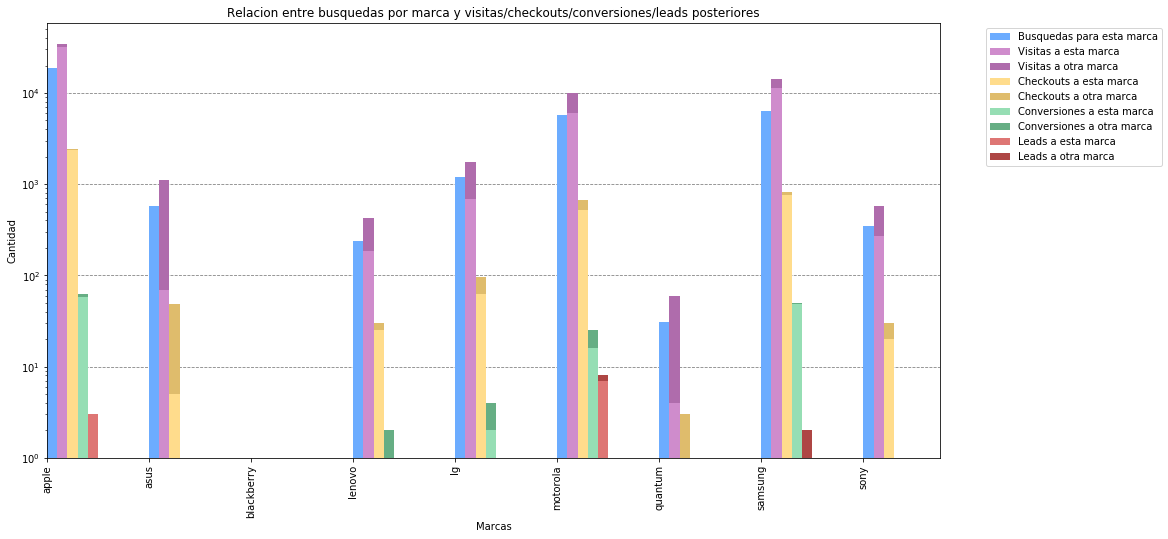

In [11]:
colores_visitas = ['#cf8ccc','#af6cac']
colores_cheackouts = ['#ffdc8c','#dfbc6c']
colores_conversion = ['#96deb4','#66ae84']
colores_lead = ['#de7674','#ae4644']
vcm = 'Busquedas para esta marca'
vam = 'Visitas a esta marca'
vao = 'Visitas a otra marca'
coam = 'Checkouts a esta marca'
coao = 'Checkouts a otra marca'
cam = 'Conversiones a esta marca'
cao = 'Conversiones a otra marca'
lam = 'Leads a esta marca'
lao = 'Leads a otra marca'
df3.columns = [vcm, vam, vao, coam, coao, cam, cao, lam, lao]
fig, ax = plt.subplots()
df3.loc[:,[vcm]].plot.bar(stacked=True, color='#6cacff', width=0.1, position=0, ax=ax)
df3.loc[:,[vam, vao]].plot.bar(stacked=True, color=colores_visitas, width=0.1, position=-1, ax=ax)
df3.loc[:,[coam, coao]].plot.bar(stacked=True, color=colores_cheackouts, width=0.1, position=-2, ax=ax)
df3.loc[:,[cam, cao]].plot.bar(stacked=True, color=colores_conversion, width=0.1, position=-3, ax=ax)
df3.loc[:,[lam, lao]].plot.bar(stacked=True, color=colores_lead, width=0.1, position=-4, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(16.0, 8.0)
plt.legend(loc=9, bbox_to_anchor=(1.15, 1.0))
plt.title("Relacion entre busquedas por marca y visitas/checkouts/conversiones/leads posteriores")
plt.show()

Ahora separo en 4 gráficos las comparacion por marca de las busquedas, visitas, checkout y conversion. Estos gráficos de escala lineal permiten una mejor comparacion entre marcas.

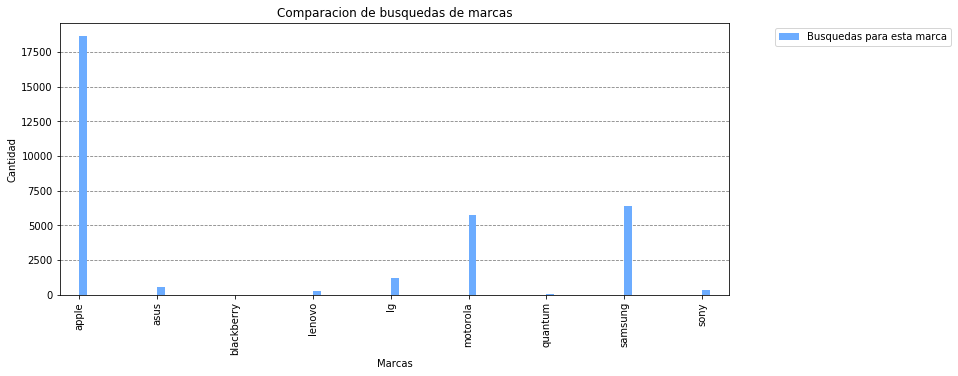

In [12]:
fig, ax = plt.subplots()
df3.loc[:,[vcm]].plot.bar(stacked=True, color='#6cacff', width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de busquedas de marcas")
plt.show()

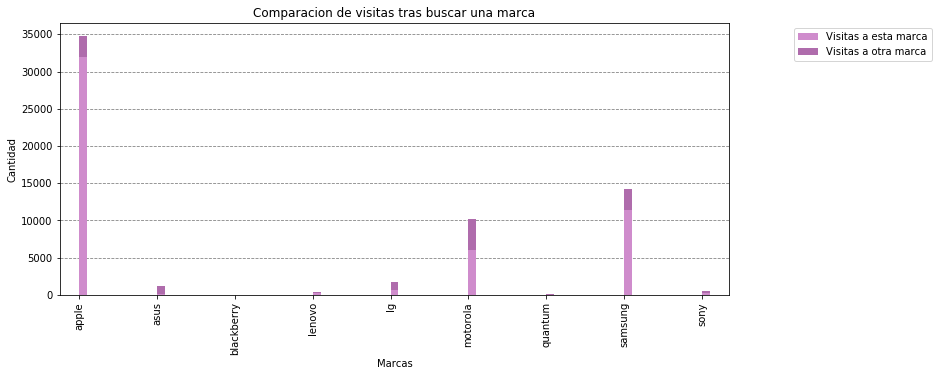

In [13]:
fig, ax = plt.subplots()
df3.loc[:,[vam, vao]].plot.bar(stacked=True, color=colores_visitas, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de visitas tras buscar una marca")
plt.show()

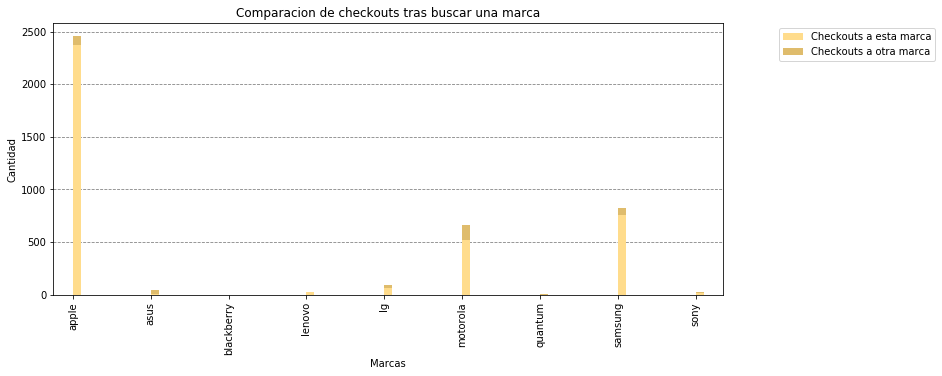

In [14]:
fig, ax = plt.subplots()
df3.loc[:,[coam, coao]].plot.bar(stacked=True, color=colores_cheackouts, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de checkouts tras buscar una marca")
plt.show()

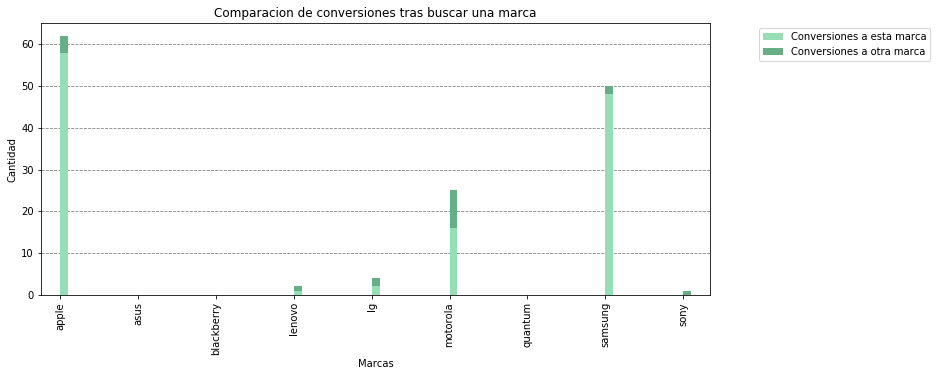

In [15]:
fig, ax = plt.subplots()
df3.loc[:,[cam, cao]].plot.bar(stacked=True, color=colores_conversion, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de conversiones tras buscar una marca")
plt.show()

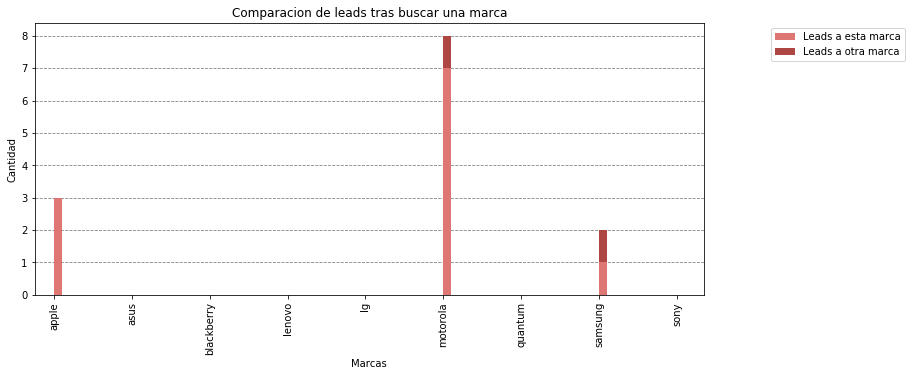

In [16]:
fig, ax = plt.subplots()
df3.loc[:,[lam, lao]].plot.bar(stacked=True, color=colores_lead, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de leads tras buscar una marca")
plt.show()

### Repito el procedimiento para búsquedas con marcas mal tipeadas

In [17]:
def son_similares(palabra, marca, mejor_ratio, r):
    r[0] = sm(None, palabra, marca).ratio() 
    return r[0] > mejor_ratio and r[0] < 1.0

def obtener_marca(x):
    if (type(x) == float):
        return np.nan
    mejor_ratio = 0.7
    mejor_palabra = np.nan
    r = [0.0]
    for palabra in x.split():
        palabra = unicode(palabra, 'utf-8')
        palabra = ud.normalize('NFKD', palabra).encode('ASCII', 'ignore')
        palabra = palabra.decode("utf-8")
        if (son_similares(palabra, 'asus', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'asus'
        if (son_similares(palabra, 'live', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'asus'
        if (son_similares(palabra, 'zenfone', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'asus'
        if (son_similares(palabra, 'blackberry', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'blackberry'
        if (son_similares(palabra, 'lg', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'lg'
        if (palabra != 'novo' and palabra != 'novos' and son_similares(palabra, 'lenovo', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'lenovo'
        if (son_similares(palabra, 'vibe', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'lenovo'
        if (son_similares(palabra, 'motorola', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'motorola'
        if (son_similares(palabra, 'moto', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'motorola'
        if (son_similares(palabra, 'quantum', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'quantum'
        if (son_similares(palabra, 'samsung', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'samsung'
        if (son_similares(palabra, 'galaxy', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'samsung'
        if (son_similares(palabra, 'sony', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'sony'
        if (son_similares(palabra, 'xperia', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'sony'
        if (son_similares(palabra, 'apple', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'apple'
        if (son_similares(palabra, 'iphone', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'apple'
        if (son_similares(palabra, 'ipad', mejor_ratio, r)):
            mejor_ratio = r[0]
            mejor_palabra = 'apple'
    return mejor_palabra

def obtener_marca_de_busqueda(x):
    return obtener_marca(x.iloc[0])

dfg = df.groupby('search', as_index=False)
df2['busquedas'] = dfg['search_term'].transform(obtener_marca_de_busqueda)
df2['nmodel'] = df2.apply(lambda x: obtener_marca(x['model']), axis=1)

df2['bcm'] = ((df2['event'] == 'searched products') & (df2['busquedas'])).astype(int)
df2['vam'] = ((df2['event'] == 'viewed product') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['vao'] = ((df2['event'] == 'viewed product') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)
df2['coam'] = ((df2['event'] == 'checkout') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['coao'] = ((df2['event'] == 'checkout') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)
df2['cam'] = ((df2['event'] == 'conversion') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['cao'] = ((df2['event'] == 'conversion') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)
df2['lam'] = ((df2['event'] == 'lead') & (df2['busquedas']) & (df2['busquedas'] == df2['nmodel'])).astype(int)
df2['lao'] = ((df2['event'] == 'lead') & (df2['busquedas']) & (df2['busquedas'] != df2['nmodel'])).astype(int)

print(df2.loc[1000:2000, ['search', 'event', 'search_term', 'model', 'nmodel', 'busquedas', 'bcm', 'vam', 'vao', 'coam', 'coao', 'cam', 'cao', 'lam', 'lao']])

      search              event              search_term                         model  nmodel busquedas  bcm  vam  vao  coam  coao  cam  cao  lam  lao
1108     102  searched products                   iphone                           NaN     NaN       NaN    0    0    0     0     0    0    0    0    0
1112     104  searched products  samsung galaxy j7 metal                           NaN     NaN       NaN    0    0    0     0     0    0    0    0    0
1113     104     viewed product                      NaN  samsung galaxy j7 2016 metal     NaN       NaN    0    0    0     0     0    0    0    0    0
1114     104     viewed product                      NaN  samsung galaxy j7 2016 metal     NaN       NaN    0    0    0     0     0    0    0    0    0
1115     104     viewed product                      NaN  samsung galaxy j7 2016 metal     NaN       NaN    0    0    0     0     0    0    0    0    0
1116     104     viewed product                      NaN  samsung galaxy j7 2016 metal  

In [18]:
df3 = df2.loc[:, ['busquedas', 'bcm', 'vam', 'vao', 'coam', 'coao', 'cam', 'cao', 'lam', 'lao']]
df3 = df3.set_index('busquedas')
df3.index.names = ['marcas']
df3 = df3.astype(float)
df3 = df3.groupby(level=0).sum()
df3

,bcm,vam,vao,coam,coao,cam,cao,lam,lao
marcas,,,,,,,,,
apple,662.0,0.0,943.0,0.0,80.0,0.0,1.0,0.0,0.0
asus,188.0,0.0,198.0,0.0,8.0,0.0,0.0,0.0,1.0
blackberry,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lenovo,15.0,0.0,20.0,0.0,2.0,0.0,0.0,0.0,0.0
lg,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
motorola,219.0,0.0,251.0,0.0,24.0,0.0,1.0,0.0,1.0
quantum,5.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
samsung,891.0,0.0,1385.0,0.0,113.0,0.0,15.0,0.0,0.0
sony,18.0,0.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0


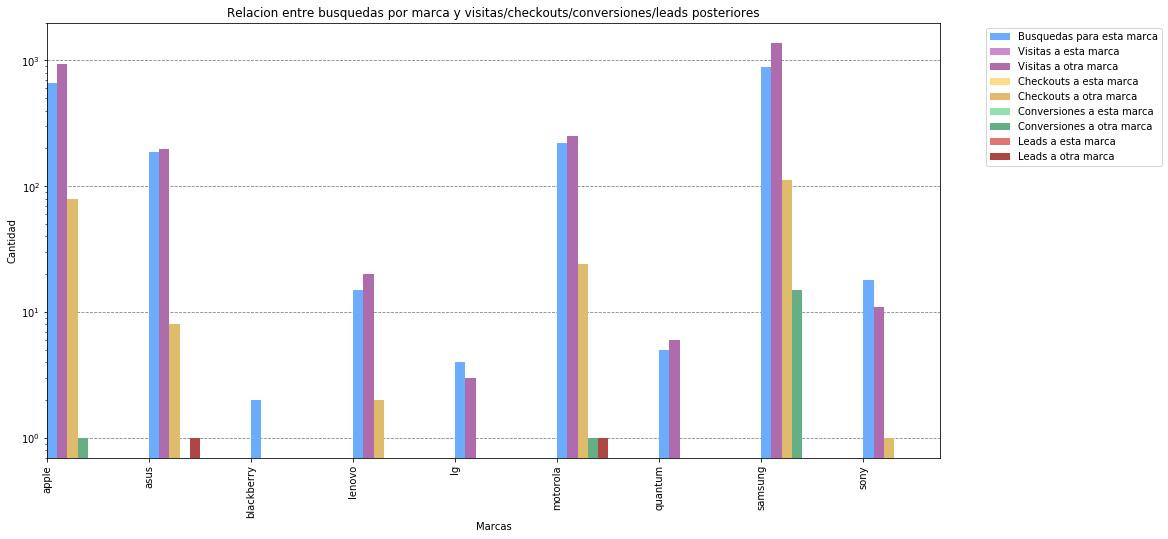

In [19]:
df3.columns = [vcm, vam, vao, coam, coao, cam, cao, lam, lao]
fig, ax = plt.subplots()
df3.loc[:,[vcm]].plot.bar(stacked=True, color='#6cacff', width=0.1, position=0, ax=ax)
df3.loc[:,[vam, vao]].plot.bar(stacked=True, color=colores_visitas, width=0.1, position=-1, ax=ax)
df3.loc[:,[coam, coao]].plot.bar(stacked=True, color=colores_cheackouts, width=0.1, position=-2, ax=ax)
df3.loc[:,[cam, cao]].plot.bar(stacked=True, color=colores_conversion, width=0.1, position=-3, ax=ax)
df3.loc[:,[lam, lao]].plot.bar(stacked=True, color=colores_lead, width=0.1, position=-4, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(16.0, 8.0)
plt.legend(loc=9, bbox_to_anchor=(1.15, 1.0))
plt.title("Relacion entre busquedas por marca y visitas/checkouts/conversiones/leads posteriores")
plt.show()

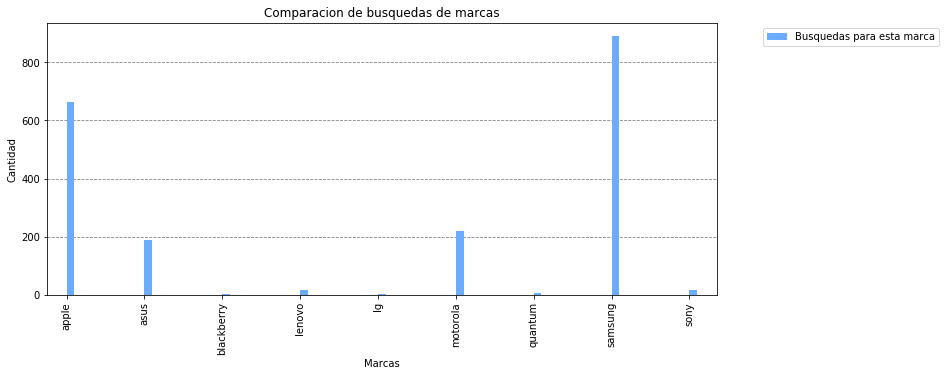

In [20]:
fig, ax = plt.subplots()
df3.loc[:,[vcm]].plot.bar(stacked=True, color='#6cacff', width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de busquedas de marcas")
plt.show()

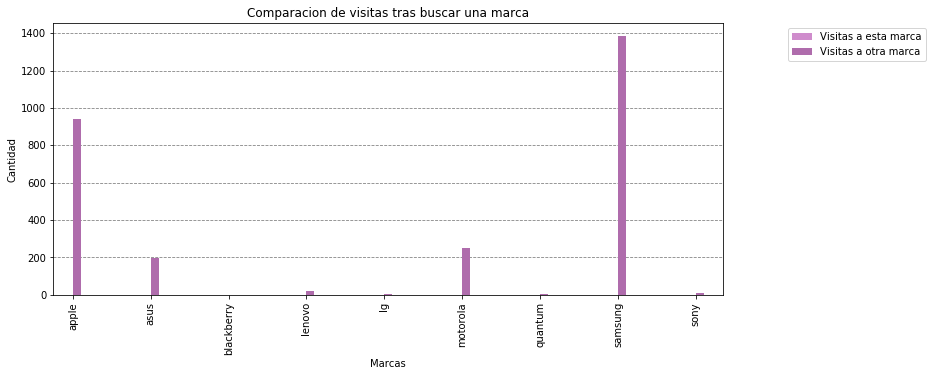

In [21]:
fig, ax = plt.subplots()
df3.loc[:,[vam, vao]].plot.bar(stacked=True, color=colores_visitas, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de visitas tras buscar una marca")
plt.show()

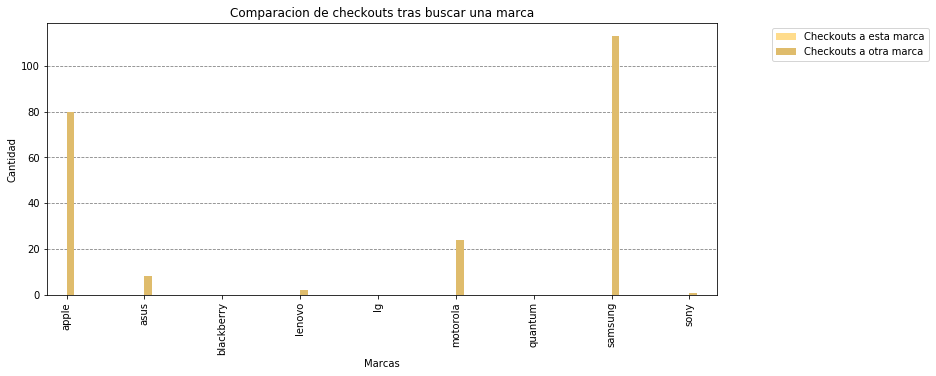

In [22]:
fig, ax = plt.subplots()
df3.loc[:,[coam, coao]].plot.bar(stacked=True, color=colores_cheackouts, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de checkouts tras buscar una marca")
plt.show()

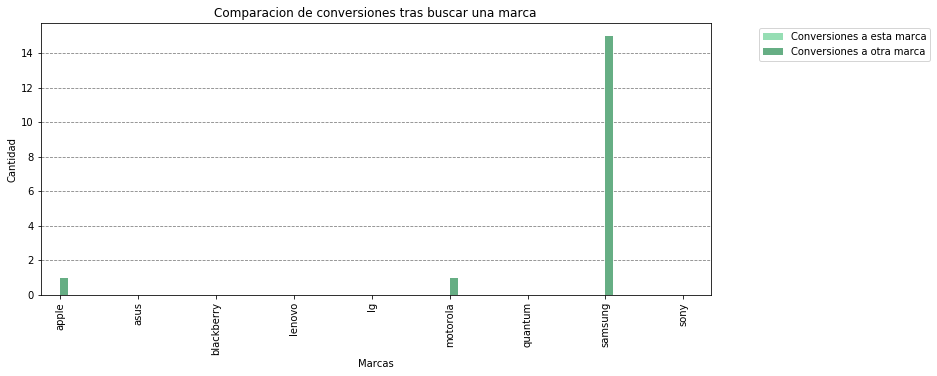

In [23]:
fig, ax = plt.subplots()
df3.loc[:,[cam, cao]].plot.bar(stacked=True, color=colores_conversion, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de conversiones tras buscar una marca")
plt.show()

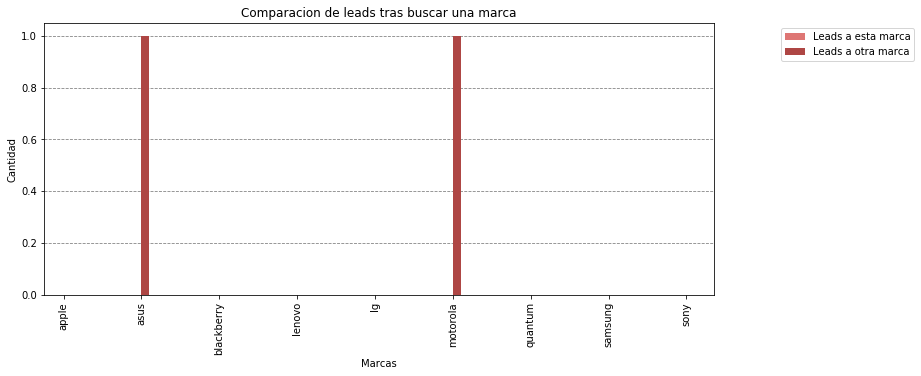

In [24]:
fig, ax = plt.subplots()
df3.loc[:,[lam, lao]].plot.bar(stacked=True, color=colores_lead, width=0.1, position=0, ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.xlabel("Marcas")
plt.ylabel("Cantidad")
plt.yscale('linear')
fig = plt.gcf()
fig.set_size_inches(12.0, 5.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1.0))
plt.title("Comparacion de leads tras buscar una marca")
plt.show()

In [457]:
#for cat in df['model'].dropna().cat.categories:
#    print('model: %s'%(cat))